# Elo Rankings

**- Great Introduction to Tennis ELO here** : http://www.tennisabstract.com/blog/2019/12/03/an-introduction-to-tennis-elo/


**- Github Repo that computes ELO using Sackmann's data** : https://github.com/hdai/elo_tennis

## Importing libraries and the data

In [46]:
# Importing libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os  
from google.colab import drive
from tqdm.notebook import tqdm
from sklearn.metrics import brier_score_loss
import random
import seaborn as sns
import itertools

drive.mount('/content/drive')
pd.set_option('display.max_columns', None)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##  Defining functions for the ELO Model

In [4]:
def KFactor(matches_played: int) -> float:
  """
  Function that defines the K factor assumptions used in the ELO model 
  """
  K = 250
  offset = 5
  shape = 0.4
  return K/(matches_played + offset)**shape

In [5]:
def calcExpProba(playerA_rating: float, playerB_rating: float) -> float:
  """
  Function that computes the win probability of player A based on his rating and his opponent's
  """
  exp_proba = 1/(1+10**((playerB_rating - playerA_rating)/400))
  return exp_proba

In [6]:
def updateELO(old_elo: float, K: float, actual_score: bool, expected_proba: float) -> float:
  """
  Function that updates the ELO for a given player based on the K factor (which includes the number of matches played in the past),
  the old elo, and the difference between the actual and expected scores 
  """
  new_elo = old_elo + K*(actual_score - expected_proba)	
  return new_elo

## Computing ELO for 2003 season using 10 years of data 

In [7]:
# Defining the right path 
training_data_path = '/content/drive/MyDrive/Classes/Sports Analytics/Sports Analytics - Project/Data/old_matches' 
os.chdir(training_data_path) 

# Years we will use to compute the ELOs 
years = ['1994','1995','1996','1997','1998','1999','2000','2001','2002','2003']

Objective: get a dataframe containing player name, id, nationality, one column for the elo and one last for peak elo, and one for the number of matches played  
At the beginning, initialize all elos to 1500 

In [8]:
# Initializing empty dataframe 
df_players_rating = pd.DataFrame(columns=['player_name','player_id','nationality','elo','peak_elo','matches_played'])

for year in tqdm(years):
  # Read data for the current year 
  table_name = 'atp_matches_{}.csv'.format(str(year))
  df_year = pd.read_csv(table_name)
  # We append winner_name, winner_id and winner_nationality to the dataframe and set elos to 1500 
  winner_df = df_year[['winner_name','winner_id','winner_ioc']].copy()
  winner_df['elo'] = 1500 
  winner_df['peak_elo'] = 1500 
  winner_df['matches_played'] = 0 
  winner_df.rename(columns={'winner_name':'player_name','winner_id':'player_id','winner_ioc':'nationality'},inplace=True)
  df_players_rating = pd.concat([df_players_rating, winner_df], ignore_index=True)
  # We append loser_name, loser_id and loser_nationality to the dataframe and set elos to 1500 
  loser_df = df_year[['loser_name','loser_id','loser_ioc']].copy()
  loser_df['elo'] = 1500 
  loser_df['peak_elo'] = 1500 
  loser_df['matches_played'] = 0 
  loser_df.rename(columns={'loser_name':'player_name','loser_id':'player_id','loser_ioc':'nationality'},inplace=True)
  df_players_rating = pd.concat([df_players_rating, loser_df], ignore_index=True)
  # Finally we drop duplicates to keep unique players for the current year 
  df_players_rating.drop_duplicates(inplace=True, ignore_index=True)

  0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
print(df_players_rating.shape)
df_players_rating.head(10)

(1522, 6)


,player_name,player_id,nationality,elo,peak_elo,matches_played
0,Thomas Muster,101404,AUT,1500,1500,0
1,Grant Stafford,101917,RSA,1500,1500,0
2,Patrick Rafter,102158,AUS,1500,1500,0
3,Brett Steven,101601,NZL,1500,1500,0
4,Karel Novacek,101120,CZE,1500,1500,0
5,Yevgeny Kafelnikov,102338,RUS,1500,1500,0
6,Jamie Morgan,101920,AUS,1500,1500,0
7,David Rikl,101866,CZE,1500,1500,0
8,Jan Apell,101659,SWE,1500,1500,0
9,Kenneth Carlsen,102202,DEN,1500,1500,0


In [10]:
def ComputeELO(years: list, df_players_rating: pd.DataFrame) -> pd.DataFrame: 
  """
  Function that computes the ELOs of all the players that played during the provided seasons 
  and stores their updated ELO in df_players_rating 
  """
  # Let's make a copy of the input so we don't modify it 
  df_final_rating = df_players_rating.copy()
  # We will loop through each year and match played 
  for year in tqdm(years): 
    table_name = 'atp_matches_{}.csv'.format(str(year))
    df_year = pd.read_csv(table_name)
    df_year.sort_values('tourney_date', ascending=True, inplace=True, ignore_index=True) # sorting matches in chronological order 
    # Iterate through each match of that year 
    for k in range(df_year.shape[0]): 
      # Identify winner and loser id, as well as their index in the ratings df 
      w_id, l_id = df_year.loc[k,'winner_id'], df_year.loc[k,'loser_id']
      w_index = df_final_rating[df_final_rating['player_id']==w_id].index[0]
      l_index = df_final_rating[df_final_rating['player_id']==l_id].index[0]
      # Extract their current elos 
      w_elo = df_final_rating.loc[w_index,'elo'] 
      l_elo = df_final_rating.loc[l_index,'elo']
      # Compute expected_proba for the winner to actually win the match 
      expected_proba = calcExpProba(w_elo, l_elo)
      # Compute K factor 
      w_matches_played = df_final_rating.loc[w_index,'matches_played'] 
      l_matches_played = df_final_rating.loc[l_index,'matches_played'] 
      w_k_factor, l_k_factor = KFactor(w_matches_played), KFactor(l_matches_played) 
      # Update ELOs
      df_final_rating.loc[w_index,'elo'] = updateELO(w_elo, w_k_factor, 1, expected_proba)
      df_final_rating.loc[l_index,'elo'] = updateELO(l_elo, l_k_factor, 0, 1-expected_proba)
      # Update winner peak ELOs if necessary 
      if updateELO(w_elo, w_k_factor, 1, expected_proba) > df_final_rating.loc[w_index,'peak_elo']:
        df_final_rating.loc[w_index,'peak_elo'] = updateELO(w_elo, w_k_factor, 1, expected_proba)
      # Update number of matches 
      df_final_rating.loc[w_index,'matches_played'] += 1 
      df_final_rating.loc[l_index,'matches_played'] += 1 
  # We convert the two ELO columns to integer values 
  df_final_rating['elo'] = df_final_rating['elo'].astype(int)
  df_final_rating['peak_elo'] = df_final_rating['peak_elo'].astype(int)
  # We sort the resulting dataframe by descending ELO ratings 
  df_final_rating.sort_values('elo', ascending=False, inplace=True, ignore_index=True)
  return df_final_rating 

In [11]:
df_ratings_2003 = ComputeELO(years, df_players_rating)

  0%|          | 0/10 [00:00<?, ?it/s]

In [12]:
df_ratings_2003

,player_name,player_id,nationality,elo,peak_elo,matches_played
0,Roger Federer,103819,SUI,2093,2093,348
1,Andy Roddick,104053,USA,2065,2138,234
2,Andre Agassi,101736,USA,2053,2112,626
3,Guillermo Coria,103909,ARG,2032,2078,164
4,Lleyton Hewitt,103720,AUS,2027,2125,387
...,...,...,...,...,...,...
1517,Scott Humphries,102795,USA,1199,1500,14
1518,Jose Luis Noriega,101641,PER,1197,1505,10
1519,Andrian Raturandang,102832,INA,1182,1500,20
1520,Mehdi Tahiri,103029,MAR,1158,1500,12


In [13]:
# Gasquet Rating at the end of 2003 
df_ratings_2003[df_ratings_2003['player_name']=='Richard Gasquet']

,player_name,player_id,nationality,elo,peak_elo,matches_played
780,Richard Gasquet,104755,FRA,1460,1598,16


In [14]:
# Nadal Rating at the end of 2003 
df_ratings_2003[df_ratings_2003['player_name']=='Rafael Nadal']

,player_name,player_id,nationality,elo,peak_elo,matches_played
82,Rafael Nadal,104745,ESP,1711,1845,27


## Defining functions to make predictions and update ELOs each year

In [15]:
# Defining the right path 
training_data_path = '/content/drive/MyDrive/Classes/Sports Analytics/Sports Analytics - Project/Data/atp_matches_scores' 
os.chdir(training_data_path) 

In [16]:
def addNewPlayers(year: int, df_rating: pd.DataFrame) -> pd.DataFrame:
  """
  For a given year, function that finds the new players compared to the previous year and adds them to df_rating 
  Also initializes their ELO to 1500 
  """
  # Let's make a copy of the input so we don't modify it 
  df_final_rating = df_rating.copy()
  # Reading data 
  table_name = 'atp_matches_{}.csv'.format(str(year))
  df_year = pd.read_csv(table_name)
  # Looking for new match winners 
  new_winners = df_year[~df_year['winner_id'].isin(df_final_rating['player_id'])][['winner_name','winner_id','winner_ioc']].copy()
  new_winners['elo'], new_winners['peak_elo'], new_winners['matches_played'] = 1500, 1500, 0
  new_winners.rename(columns={'winner_name':'player_name','winner_id':'player_id','winner_ioc':'nationality'}, inplace=True)
  # Looking for new match losers 
  new_losers = df_year[~df_year['loser_id'].isin(df_final_rating['player_id'])][['loser_name','loser_id','loser_ioc']].copy()
  new_losers['elo'], new_losers['peak_elo'], new_losers['matches_played'] = 1500, 1500, 0
  new_losers.rename(columns={'loser_name':'player_name','loser_id':'player_id','loser_ioc':'nationality'}, inplace=True)
  # Concatenating both dataframes and droping duplicates to keep unique players
  new_players_clean = pd.concat([new_winners,new_losers], ignore_index=True)
  new_players_clean.drop_duplicates(inplace=True, ignore_index=True)
  # Adding the new players to the existing pool of players 
  df_final_rating = pd.concat([df_final_rating, new_players_clean], ignore_index=True)
  return df_final_rating

In [17]:
def makePredictions(year: int, df_ratings_previous_year: pd.DataFrame): 
  """
  Function that takes as input the year to make predictions and the dataframe of ratings 
  Compares two models: 
  - One using ATP rankings: simple model where the player with the best ranking is predicted to win the match. However, no probabilities involved with this model (thus no Brier score)
  - One using ELO rankings, as seen above 
  """
  # Looking for new players and adding them to the dataframe, while initializing their ELO at 1500  
  df_ratings = addNewPlayers(year, df_ratings_previous_year) 
  # Create dataframe that will store the results 
  df_results = pd.DataFrame(index=['atp_ranking_model','elo_model'], columns=['total_matches_played','correct_predictions','accuracy','brier_score'])
  # Reading table 
  table_name = 'atp_matches_{}.csv'.format(str(year))
  df_year = pd.read_csv(table_name)
  df_year.sort_values('tourney_date', ascending=True, inplace=True, ignore_index=True) # sorting matches in chronological order 
  # Creating additional features
  total_matches_played = int(df_year.shape[0]) 
  list_expected_output = [1]*total_matches_played  # Binary output (0 or 1 for loss or win) : we always focus on the winner of the match so the output is 1 each time 
  atp_ranking_predicted_output = [] # Fill this list with binary outcomes (win or loss)
  elo_predicted_output = [] # Fill this list with binary outcomes (win or loss)
  elo_predicted_proba = [] # Fill this list with expected win probability 
  # Iterate through each match of that year 
  for k in range(total_matches_played):
    # Identify winner and loser id, as well as their index in the ratings df 
    w_id, l_id = df_year.loc[k,'winner_id'], df_year.loc[k,'loser_id']
    w_index = df_ratings[df_ratings['player_id']==w_id].index[0]
    l_index = df_ratings[df_ratings['player_id']==l_id].index[0]
    # Extract their current elos and rankings 
    w_elo, w_ranking = df_ratings.loc[w_index,'elo'], df_year.loc[k,'winner_rank']
    l_elo, l_ranking = df_ratings.loc[l_index,'elo'], df_year.loc[k,'loser_rank']
    # Compute expected_proba for the winner to actually win the match 
    expected_proba = calcExpProba(w_elo, l_elo)
    # Fill the lists of results 
    elo_predicted_proba.append(expected_proba)
    if expected_proba > 0.5:
      elo_predicted_output.append(1)
    else:
      elo_predicted_output.append(0)
    if w_ranking < l_ranking:
      atp_ranking_predicted_output.append(1)
    else:
      atp_ranking_predicted_output.append(0)
  # Compute brier score
  brier_score = brier_score_loss(list_expected_output, elo_predicted_proba)
  # Fill final dataframe 
  df_results.loc['atp_ranking_model','total_matches_played'] = total_matches_played 
  df_results.loc['elo_model','total_matches_played'] = total_matches_played
  df_results.loc['atp_ranking_model','correct_predictions'] = sum(atp_ranking_predicted_output)
  df_results.loc['elo_model','correct_predictions'] = sum(elo_predicted_output)
  df_results.loc['atp_ranking_model','accuracy'] = round(sum(atp_ranking_predicted_output) / total_matches_played,3) 
  df_results.loc['elo_model','accuracy'] = round(sum(elo_predicted_output) / total_matches_played,3) 
  df_results.loc['elo_model','brier_score'] = round(brier_score,3)
  return df_results 

In [18]:
makePredictions(2004, df_ratings_2003)

,total_matches_played,correct_predictions,accuracy,brier_score
atp_ranking_model,3288,2061,0.627,NaN
elo_model,3288,2083,0.634,0.228


In [19]:
def updateAllELO(year: int, df_rating: pd.DataFrame) -> pd.DataFrame: 
  """ 
  Function that updates the ELO rating dataframe using the previous ratings and the data for the current year 
  If a pleayer is new in the season, ELO initialized at 1500 and then updated at each match 
  """
  # Looking for new players and adding them to the dataframe, while initializing their ELO at 1500  
  df_rating_with_new_players = addNewPlayers(year, df_rating) 
  # Updating the ELOs for the year provided using the ComputeELO function 
  df_final_rating  = ComputeELO([year], df_rating_with_new_players)
  return df_final_rating 

In [20]:
df_ratings_2004 = updateAllELO(2004, df_ratings_2003)

  0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
df_ratings_2004

,player_name,player_id,nationality,elo,peak_elo,matches_played
0,Roger Federer,103819,SUI,2237,2237,429
1,Lleyton Hewitt,103720,AUS,2075,2125,473
2,Andy Roddick,104053,USA,2056,2138,326
3,Andre Agassi,101736,USA,2026,2112,676
4,Patrick Rafter,102158,AUS,1976,2011,525
...,...,...,...,...,...,...
1637,Scott Humphries,102795,USA,1199,1500,14
1638,Jose Luis Noriega,101641,PER,1197,1505,10
1639,Andrian Raturandang,102832,INA,1182,1500,20
1640,Neil Borwick,101398,AUS,1157,1500,16


## Full predictions for 2004-2022 period 

In [22]:
# Defining the right path 
training_data_path = '/content/drive/MyDrive/Classes/Sports Analytics/Sports Analytics - Project/Data/atp_matches_scores' 
os.chdir(training_data_path)

In [39]:
# Filtering all players who were active in 2004-2022
all_matches = pd.read_csv('merged_atp_matches.csv')
all_matches['year'] = [int(str(date)[:4]) for date in all_matches['tourney_date']]
matches_04_22 = all_matches[all_matches['year']>=2004].copy()
all_winners, all_losers = list(matches_04_22['winner_name'].unique()), list(matches_04_22['loser_name'].unique())
unique_players = list(set(all_winners + all_losers))
players_04_22 = []
for player in tqdm(unique_players): 
  player_df = matches_04_22[(matches_04_22['winner_name']==player) | (matches_04_22['loser_name']==player)]
  if list(player_df['year'].unique()) == list(matches_04_22['year'].unique()):
    players_04_22.append(player)

  0%|          | 0/2024 [00:00<?, ?it/s]

In [41]:
def predict2004to2022(list_years:list, df_previous_ratings:pd.DataFrame) -> pd.DataFrame:
  """
  Function that makes yearly match predictions from 2004 to 2022 
  Proceeds sequentially year by year : 
  - Using the ELO standings of the previous year, makes predictions for the matches of the current year  
  - Update ELOs for the current year  
  - Iterate again for the next year
  - Focus on following the Nadal Gasquet confrontations 
  """
  # Creating dataframe where we will store results 
  df_results = pd.DataFrame(index=list_years, columns=['total_matches_played','correct_predictions','accuracy','brier_score',
                                                       'nadal_elo','gasquet_elo','nadal_ranking','gasquet_ranking','nadal_matches','gasquet_matches'])
  # Looping through each year 
  for year in tqdm(list_years):
    # Reading table 
    table_name = 'atp_matches_{}.csv'.format(str(year))
    df_year = pd.read_csv(table_name)
    df_year.sort_values('tourney_date', ascending=True, inplace=True, ignore_index=True) # sorting matches in chronological order 
    # We first make predictions for that year 
    preds_df = makePredictions(year, df_previous_ratings)
    # We then update the elos using this year's matches 
    df_new_ratings = updateAllELO(year, df_previous_ratings)
    # We now fill the dataframe with results for that year 
    df_results.loc[year, 'total_matches_played'] = preds_df.loc['elo_model','total_matches_played']
    df_results.loc[year, 'correct_predictions'] = preds_df.loc['elo_model','correct_predictions']
    df_results.loc[year, 'accuracy'] = preds_df.loc['elo_model','accuracy']
    df_results.loc[year, 'brier_score'] = preds_df.loc['elo_model','brier_score']
    df_results.loc[year, 'nadal_elo'] = int(df_new_ratings[df_new_ratings['player_name']=='Rafael Nadal']['elo'])
    df_results.loc[year, 'gasquet_elo'] = int(df_new_ratings[df_new_ratings['player_name']=='Richard Gasquet']['elo'])
    df_results.loc[year, 'lopez_elo'] = int(df_new_ratings[df_new_ratings['player_name']=='Feliciano Lopez']['elo'])
    df_results.loc[year, 'kohlschreiber_elo'] = int(df_new_ratings[df_new_ratings['player_name']=='Philipp Kohlschreiber']['elo'])
    df_results.loc[year, 'wawrinka_elo'] = int(df_new_ratings[df_new_ratings['player_name']=='Stan Wawrinka']['elo'])
    df_results.loc[year, 'seppi_elo'] = int(df_new_ratings[df_new_ratings['player_name']=='Andreas Seppi']['elo'])
    df_results.loc[year, 'simon_elo'] = int(df_new_ratings[df_new_ratings['player_name']=='Gilles Simon']['elo'])
    df_results.loc[year, 'djokovic_elo'] = int(df_new_ratings[df_new_ratings['player_name']=='Novak Djokovic']['elo'])
    df_results.loc[year, 'monfils_elo'] = int(df_new_ratings[df_new_ratings['player_name']=='Gael Monfils']['elo'])
    df_results.loc[year, 'verdasco_elo'] = int(df_new_ratings[df_new_ratings['player_name']=='Fernando Verdasco']['elo'])
    # Updating df_previous_ratings for the predictions of the following year
    df_previous_ratings = df_new_ratings.copy()
  return df_results

In [42]:
# Making predictions 
list_years = [2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
df_previous_ratings = df_ratings_2003

df_results = predict2004to2022(list_years, df_previous_ratings)
df_results

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

,total_matches_played,correct_predictions,accuracy,brier_score,nadal_elo,gasquet_elo,nadal_ranking,gasquet_ranking,nadal_matches,gasquet_matches,lopez_elo,kohlschreiber_elo,wawrinka_elo,seppi_elo,simon_elo,djokovic_elo,monfils_elo,verdasco_elo
2004,3288,2083,0.634,0.228,1819,1670,NaN,NaN,NaN,NaN,1871.0,1529.0,1353.0,1660.0,1428.0,1541.0,1684.0,1778.0
2005,3264,2072,0.635,0.225,2187,1916,NaN,NaN,NaN,NaN,1782.0,1559.0,1711.0,1775.0,1634.0,1776.0,1849.0,1839.0
2006,3267,2126,0.651,0.216,2155,1975,NaN,NaN,NaN,NaN,1729.0,1721.0,1929.0,1596.0,1675.0,1955.0,1772.0,1764.0
2007,3192,2074,0.65,0.221,2184,1954,NaN,NaN,NaN,NaN,1822.0,1813.0,1888.0,1758.0,1839.0,2080.0,1797.0,1886.0
2008,3123,2066,0.662,0.218,2270,1892,NaN,NaN,NaN,NaN,1866.0,1908.0,1895.0,1778.0,2009.0,2151.0,1971.0,1906.0
2009,3085,2081,0.675,0.206,2227,1903,NaN,NaN,NaN,NaN,1777.0,1866.0,1917.0,1775.0,1924.0,2243.0,1981.0,2000.0
2010,3030,2040,0.673,0.213,2256,1894,NaN,NaN,NaN,NaN,1800.0,1865.0,1972.0,1758.0,1927.0,2179.0,2046.0,1942.0
2011,3015,1995,0.662,0.213,2248,1963,NaN,NaN,NaN,NaN,1930.0,1849.0,1922.0,1802.0,1898.0,2288.0,2005.0,1941.0
2012,3009,2064,0.686,0.2,2277,1972,NaN,NaN,NaN,NaN,1847.0,1885.0,1987.0,1892.0,1948.0,2338.0,1958.0,1910.0
2013,2944,1930,0.656,0.213,2357,2010,NaN,NaN,NaN,NaN,1885.0,1890.0,2053.0,1814.0,1906.0,2381.0,1915.0,1878.0


## Monte-Carlo simulations for Nadal-Gasquet confrontations

In [70]:
# Number of Nadal - Gasquet confrontations each year
# Source : ATP Tour website (https://www.atptour.com/en/players/atp-head-2-head/rafael-nadal-vs-richard-gasquet/N409/G628)
frequence_matches = {2004:1, 2005:2, 2006:0, 2007:1, 2008:2, 2009:1, 2010:0, 2011:3, 2012:0, 2013:2, 2014:1, 2015:1, 2016:0, 2017:1, 2018:1, 2019:0, 2020:0, 2021:1, 2022:1}

df_ratings = df_results

list_players = ['nadal', 'gasquet', 'lopez', 'kohlschreiber',	'wawrinka', 'seppi', 'simon', 'djokovic',	'monfils', 'verdasco']

# For all of the 10 players, let's get all of the possible matches 
list_confrontations_ordered = []
for pair in itertools.combinations(list_players,2):
  list_confrontations_ordered.append(pair)
list_confrontations = list_confrontations_ordered + [(b,a) for (a,b) in list_confrontations_ordered]

In [71]:
def getLongestStreak(match_outcomes: list) -> int:
  """
  Function that outputs the longest streak of victories from a given a binary list of match outcomes (=longest subset of 1)
  """
  current_seq_len = 0 
  max_seq_len = 0 
  for outcome in match_outcomes:
    if outcome == 1:
      current_seq_len += 1 
      if current_seq_len > max_seq_len:
        max_seq_len = current_seq_len 
    else:
      current_seq_len = 0 
  return max_seq_len 

In [72]:
def runMonteCarloSimulation(df_ratings: pd.DataFrame, list_confrontations: list, frequence_matches: dict, nb_simulations: int):
  """
  Function that runs Monte Carlo simulation for the 18 matches between all players confrontations  
  The objective is to see how many times a streak of 18 wins appear  
  For each match, the probabilities of winning are computed from the ELOs of both players at the time of the match 
  """ 
  list_simulations = []
  list_longest_streaks = []
  for confrontation in tqdm(list_confrontations):
    for n in range(nb_simulations):
      simulation = []
      for year in frequence_matches.keys():
        # If there was at least one match during this year we perform a simulation
        if frequence_matches[year] > 0:
          # Extract their ELO for that year 
          player_1_elo = df_ratings.loc[year,confrontation[0]+'_elo']
          player_2_elo = df_ratings.loc[year,confrontation[1]+'_elo']
          # Compute expected probability of winning for player 1  
          player_1_win_proba = calcExpProba(player_1_elo, player_2_elo)
          for match in range(frequence_matches[year]):
            # For each match, we generate a random number between 0 and 1 (uniform distribution)
            random_number = random.uniform(0, 1)
            # If it is inferior to player_1 win probability, then we consider that player 1 wins the match 
            if random_number < player_1_win_proba:
              simulation.append(1)
            else:
              simulation.append(0)
      longest_streak = getLongestStreak(simulation) 
      list_simulations.append(simulation)
      list_longest_streaks.append(longest_streak)
  return list_simulations, list_longest_streaks

In [77]:
list_simulations, list_longest_streaks = runMonteCarloSimulation(df_ratings, list_confrontations, frequence_matches, 1000)

  0%|          | 0/90 [00:00<?, ?it/s]

In [78]:
list_simulations[:10]

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
 [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0],
 [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
 [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1],
 [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1],
 [0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1]]

In [79]:
list_longest_streaks[:10]

[18, 8, 7, 7, 12, 5, 15, 5, 7, 4]

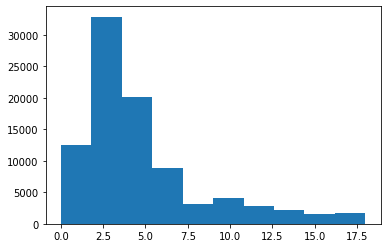

In [81]:
# Plotting the distribution of streaks 
plt.hist(list_longest_streaks)
plt.show()

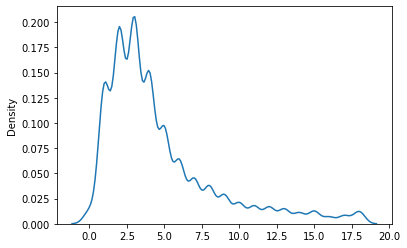

In [83]:
# Seaborn Kernel Density Plot 
sns.kdeplot(data=list_longest_streaks)

In [82]:
# Percentage of streaks of 18 matches 
streak_of_18 = len([k for k in list_longest_streaks if k==18])
print("Percentage of simulations where max streak is 18 : {} %".format(round(streak_of_18/len(list_simulations)*100,2))) 

Percentage of simulations where max streak is 18 : 1.16 %
